In [14]:
import numpy as np
import pandas as pd
import rasterio
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset


class CloudSegmentationDataset(Dataset):
    def __init__(self, csv_file: Path) -> None:
        self.data = pd.read_csv(csv_file)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        row = self.data.iloc[idx]

        channels = []
        for band in ["red", "green", "blue", "near_infrared"]:
            with rasterio.open(row[band]) as src:
                img = src.read(1).astype(np.float32) / 65535.0  # 2D image
                channels.append(img)

        image = np.stack(channels, axis=0)  # (4, H, W)

        with rasterio.open(row["target"]) as src:
            target = src.read(1).astype(np.float32)

            # Convertir 255 → 1.0
            target = target / 255.0

        # target = np.expand_dims(target, axis=0)  # (1, H, W)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


dataset = CloudSegmentationDataset(
    Path(r"C:\Users\Manon\Documents\tristan_satellite_archive\dev\satellite-dev\data\cloud_segmentation_dataset.csv"),
)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
for images, targets in loader:
    print(images.shape)  # Should be (batch_size, 4, H, W)
    print(targets.shape)  # Should be (batch_size, H, W)
    break  # Just to test the first batch

torch.Size([4, 4, 384, 384])
torch.Size([4, 384, 384])


c:\Users\Manon\Documents\tristan_satellite_archive\dev\satellite-dev\.venv\lib\site-packages\rasterio\__init__.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
import torch
import torch.nn as nn


class SimpleUNetV2(nn.Module):
    def __init__(self, dropout_rate: float = 0.3) -> None:
        super().__init__()
        self.dropout_rate = dropout_rate

        # Encoder
        self.enc1 = self.conv_block(4, 32)
        self.enc2 = self.conv_block(32, 64)

        # Bottleneck
        self.bottleneck = self.conv_block(64, 128)
        self.dropout_bottleneck = nn.Dropout2d(p=self.dropout_rate)

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.dropout_dec1 = nn.Dropout2d(p=self.dropout_rate)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64, 32)

        self.final = nn.Conv2d(32, 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_ch: int, out_ch: int) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: nn.Sequential) -> nn.Conv2d:
        # Encode
        x1 = self.enc1(x)  # (B, 32, H, W)
        x2 = self.enc2(self.pool(x1))  # (B, 64, H/2, W/2)

        # Bottleneck + dropout
        x3 = self.bottleneck(self.pool(x2))
        x3 = self.dropout_bottleneck(x3)  # (B, 128, H/4, W/4)

        # Decode
        x4 = self.up1(x3)
        x4 = self.dec1(torch.cat([x4, x2], dim=1))
        x4 = self.dropout_dec1(x4)

        x5 = self.up2(x4)
        x5 = self.dec2(torch.cat([x5, x1], dim=1))

        return self.final(x5)  # (B, 1, H, W)


from torch.utils.data import random_split

import matplotlib.pyplot as plt


def train_model(
    dataset: CloudSegmentationDataset, epochs: int = 5, batch_size: int = 4, val_split: float = 0.2
) -> SimpleUNetV2:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleUNetV2().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    # Split train/val
    n = len(dataset)
    n_val = int(val_split * n)
    n_train = n - n_val
    generator = torch.Generator().manual_seed(42)
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=generator)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    train_losses_per_epoch = []
    val_losses_per_epoch = []

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs.squeeze(1), targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                loss = loss_fn(outputs.squeeze(1), targets)
                val_losses.append(loss.item())

        train_loss = sum(train_losses) / len(train_losses)
        val_loss = sum(val_losses) / len(val_losses)
        train_losses_per_epoch.append(train_loss)
        val_losses_per_epoch.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Tracer les courbes
    plt.plot(train_losses_per_epoch, label="Train Loss")
    plt.plot(val_losses_per_epoch, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title("Courbe des pertes")
    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Train Loss: 0.5524 | Val Loss: 0.7246
Epoch 2/10 | Train Loss: 0.4663 | Val Loss: 0.5575
Epoch 3/10 | Train Loss: 0.4957 | Val Loss: 0.5086
Epoch 4/10 | Train Loss: 0.4662 | Val Loss: 0.4021
Epoch 5/10 | Train Loss: 0.4174 | Val Loss: 0.3393
Epoch 6/10 | Train Loss: 0.4555 | Val Loss: 0.3707
Epoch 7/10 | Train Loss: 0.4292 | Val Loss: 0.2735
Epoch 8/10 | Train Loss: 0.4653 | Val Loss: 0.3494
Epoch 9/10 | Train Loss: 0.3303 | Val Loss: 0.3687
Epoch 10/10 | Train Loss: 0.3619 | Val Loss: 0.2134


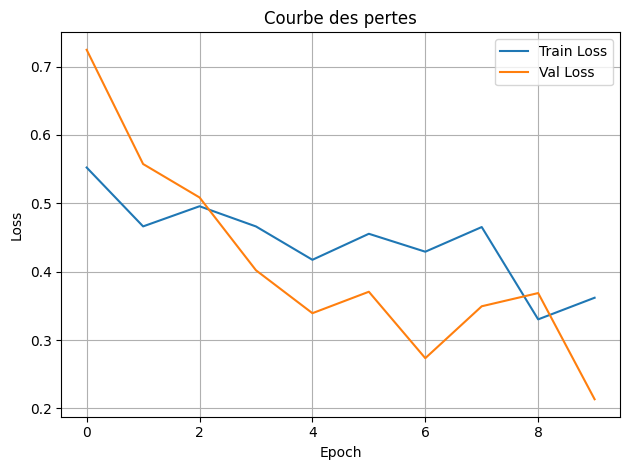

In [ ]:
subset = Subset(dataset, range(100))  # Use only the first 100 samples for quick testing
model = train_model(subset, epochs=10)
torch.save(model.state_dict(), "simple_unet_v2_subset100_epoch10.pth")


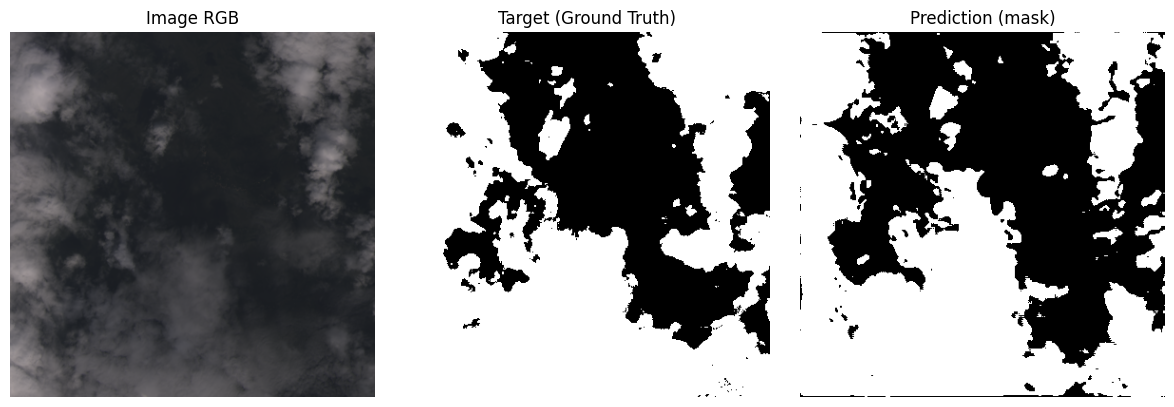

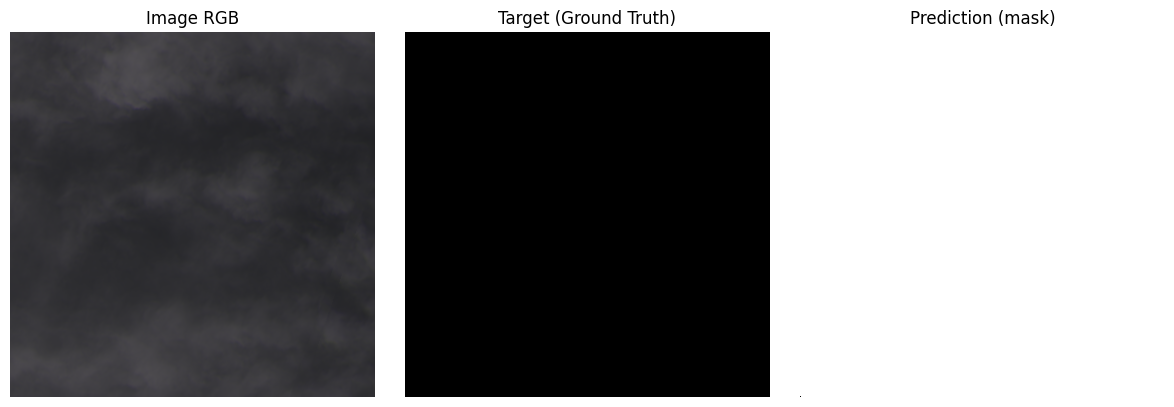

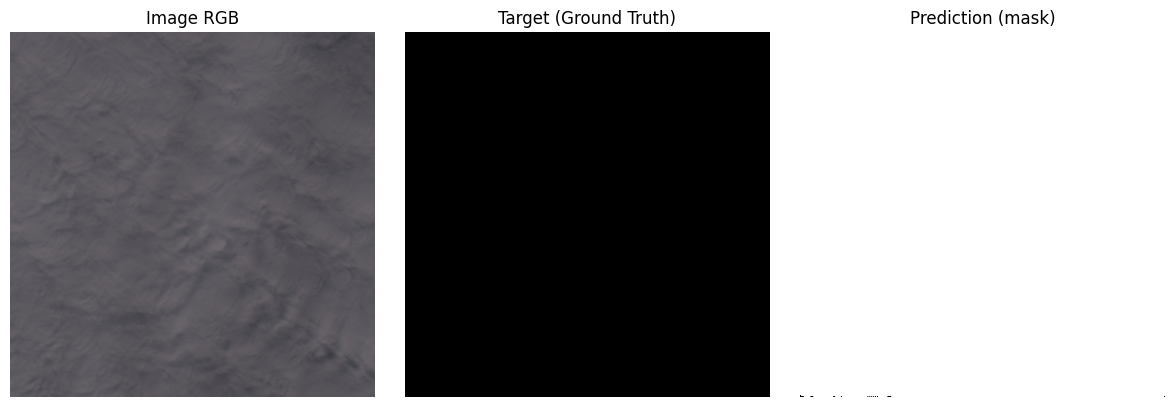

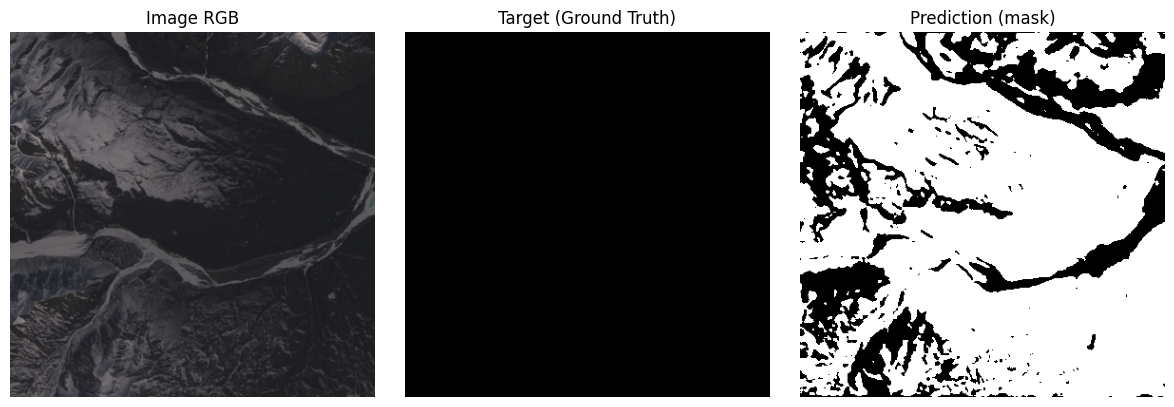

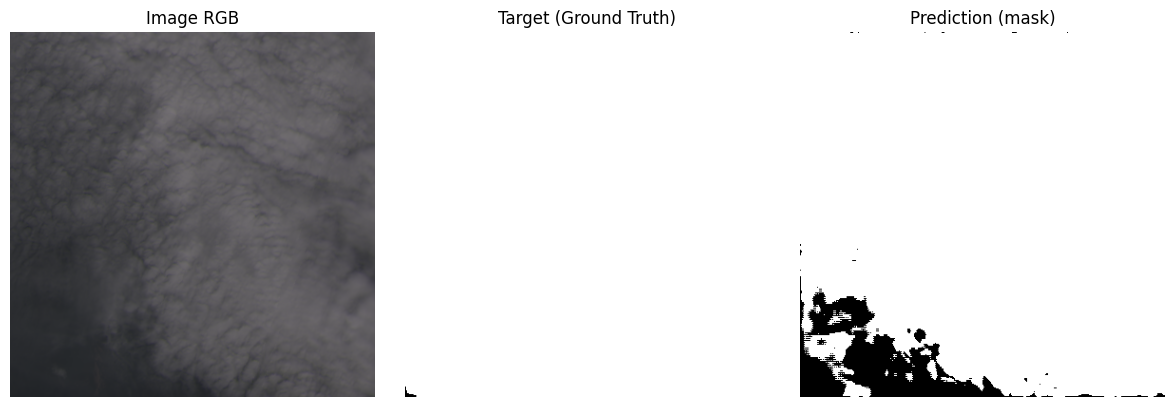

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F


def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    model.eval()
    device = next(model.parameters()).device

    for i in range(num_samples):
        image, target = dataset[i]
        image = image.to(device).unsqueeze(0)  # (1, 4, H, W)
        target_np = target.numpy()

        with torch.no_grad():
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()  # (H, W)

        image_rgb = image.squeeze().cpu()[:3].numpy().transpose(1, 2, 0)  # (H, W, 3)
        pred_mask = (pred > threshold).astype(float)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image_rgb)
        axs[0].set_title("Image RGB")
        axs[1].imshow(target_np, cmap="gray")
        axs[1].set_title("Target (Ground Truth)")
        axs[2].imshow(pred_mask, cmap="gray")
        axs[2].set_title("Prediction (mask)")

        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        plt.show()


visualize_predictions(model, dataset)
